In [1]:
import os
import pandas as pd
import glob
from dotenv import load_dotenv
import requests
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [2]:
geocodes = pd.read_excel("./GEOCodesLookup/all-geocodes-v2020.xlsx", skiprows = 4, dtype = str)

In [3]:
geocodes = geocodes[geocodes["State Code (FIPS)"] == "06"]

In [4]:
geocodes = geocodes.rename(columns = {"Area Name (including legal/statistical area description)": "CountyName"})

## Census Demographic Census Data from 2023

In [6]:
user = os.path.expanduser("~")

In [7]:
load_dotenv(os.path.join(user, "Documents", ".env"))

True

In [8]:
key = os.getenv("CENSUS_API_KEY")

In [9]:
url = "https://api.census.gov/data/2023/acs/acs5"

In [10]:
vars = [
    "NAME",
    "B01003_001E",
    "B01001_001E",
    "B02001_001E",
    "B03003_003E",
    "B19013_001E",
    "B15003_022E",
    "B15003_023E",
    "B15003_024E",
    "B15003_025E",
    "B23025_003E",
    "B23025_005E",
    "B25064_001E",
    "B25077_001E",
    "B07001_017E",
    "B07001_081E",
    "B07001_085E",
    "B25003_002E",
    "B25003_003E"
]

In [11]:
params = {"get" : ",".join(vars), "for" : "county:*"}

In [12]:
response = requests.get(url, params = params)

In [13]:
demographics = pd.DataFrame(response.json()[1:], columns = response.json()[0])

In [14]:
rename_map = {
    "NAME": "CountyName",
    "B01003_001E": "total_population",
    "B01001_001E": "total_age_population",
    "B02001_001E": "total_race_population",
    "B03003_003E": "hispanic_or_latino",
    "B19013_001E": "median_household_income",
    "B15003_022E": "bachelors_degree",
    "B15003_023E": "masters_degree",
    "B15003_024E": "professional_degree",
    "B15003_025E": "doctorate_degree",
    "B23025_003E": "labor_force",
    "B23025_005E": "unemployed",
    "B25064_001E": "median_rent",
    "B25077_001E": "median_home_value",
    "B07001_017E": "same_house_1yr_ago",
    "B07001_081E": "moved_from_same_state",
    "B07001_085E": "moved_from_different_state",
    "B25003_002E": "owner_occupied",
    "B25003_003E": "renter_occupied",
    "state": "state_fips",
    "county": "county_fips"
}

demographics = demographics.rename(columns = rename_map)

# Synthetic LODES (Where people live [RAC] vs where they work [WAC] | 2018 - 2022)

https://lehd.ces.census.gov/data/

https://www.census.gov/geographies/mapping-files/2024/geo/tiger-line-file.html

In [18]:
rac_files = glob.glob("./LODES/ca_rac_S000_JT00_*.csv.gz")
wac_files = glob.glob("./LODES/ca_wac_S000_JT00_*.csv.gz")

In [19]:
def read_lehd_file(file_path):
    # Extract year from filename
    year = int(os.path.basename(file_path).split("_")[-1].split(".")[0])
    
    # Read CSV (gzip compressed)
    df = pd.read_csv(file_path, dtype={"h_geocode": str, "w_geocode": str})
    
    # Add year column
    df["year"] = year
    
    return df


In [20]:
rac_list = [read_lehd_file(f) for f in rac_files]
rac_df = pd.concat(rac_list, ignore_index=True)

In [21]:
wac_list = [read_lehd_file(f) for f in wac_files]
wac_df = pd.concat(wac_list, ignore_index=True)

In [22]:
rac_df["state_fips"] = rac_df["h_geocode"].str[:2]     # first 2 digits = state
rac_df["county_fips"] = rac_df["h_geocode"].str[2:5]   # next 3 digits = county
rac_df["county_fips"] = rac_df["state_fips"] + rac_df["county_fips"]  # full 5-digit FIPS

In [23]:
wac_df["state_fips"] = wac_df["w_geocode"].str[:2]
wac_df["county_fips"] = wac_df["w_geocode"].str[2:5]
wac_df["county_fips"] = wac_df["state_fips"] + wac_df["county_fips"]

In [24]:
rac_county = rac_df.groupby(["county_fips","year"])["C000"].sum().reset_index()
rac_county = rac_county.rename(columns={"C000":"workers_living"})

In [25]:
wac_county = wac_df.groupby(["county_fips","year"])["C000"].sum().reset_index()
wac_county = wac_county.rename(columns={"C000":"jobs_located"})

In [26]:
county_flow = rac_county.merge(wac_county, on=["county_fips","year"])
county_flow["net_inflow"] = county_flow["jobs_located"] - county_flow["workers_living"]

In [27]:
county_flow["county_fips"] = county_flow["county_fips"].str[2:5]

In [28]:
county_flow.merge(
    geocodes[["County Code (FIPS)", "CountyName"]],
    left_on = "county_fips",
    right_on = "County Code (FIPS)",
    how = "left"
)

,county_fips,year,workers_living,jobs_located,net_inflow,County Code (FIPS),CountyName
0,001,2018,810472,813398,2926,001,Alameda County
1,001,2019,817258,807148,-10110,001,Alameda County
2,001,2020,767415,752402,-15013,001,Alameda County
3,001,2021,756046,767190,11144,001,Alameda County
4,001,2022,801985,819506,17521,001,Alameda County
...,...,...,...,...,...,...,...
285,115,2018,27305,15755,-11550,115,Yuba County
286,115,2019,27826,16194,-11632,115,Yuba County
287,115,2020,28849,16937,-11912,115,Yuba County
288,115,2021,29956,16404,-13552,115,Yuba County


# IRS Migration Data

https://www.irs.gov/statistics/soi-tax-stats-migration-data

In [31]:
irs_data_path = r"./IRSMigration"

In [32]:
csv_files = glob.glob(os.path.join(irs_data_path, "*.csv"))

In [33]:
irs_data = {}

for file in csv_files:
    key = os.path.splitext(os.path.basename(file))[0]

    irs_data[key] = pd.read_csv(file, dtype = str, encoding = "latin1")

In [34]:
irs_ca = pd.concat(irs_data.values(), ignore_index=True)

In [35]:
irs_ca = irs_ca[(irs_ca["y2_statefips"] == "06") | (irs_ca["y1_statefips"] == "06")]

# CAR

Data gathered here: https://www.car.org/marketdata/data

[Historical Housing Affordability Index](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EVgvL6PVxElFtDjAUhmBYtIBkgQMH5SsbBdeYyBIks9R9w)

[Median Time of Homes On Market](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EaAOiWPma41ArHBWwYRGQMoBlUe5JMxKixyQ0idvrn7i7Q)

[Median Prices of Homes](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EQr6lTtx5_hCmRawI-XHBkoBt0otrc47S8XAem4f8UAMrw)

[Unsold Inventory Index](https://carorg.sharepoint.com/:x:/s/CAR-RE-PublicProducts/EcDFUV4JrPtFofTmqhdiPCoBQ7S1MVK9IFU3A6BE6mt9hA)

In [42]:
hai = pd.read_csv("./CARS/Historical Housing Affordability Index(Trad.csv", skiprows = 3)
hai = hai.iloc[120:, :]

In [43]:
dom = pd.read_csv("./CARS/MedianTimeonMarketofExistingDetachedHomesHistoricalData(DOM).csv", skiprows = 3)
dom = dom.iloc[132:, :]

In [44]:
prices = pd.read_csv("./CARS/MedianPricesofExistingDetachedHomesHistoricalData(Median Price).csv", skiprows = 7)
prices = prices.iloc[132:, :]

In [45]:
uii = pd.read_csv("./CARS/UnsoldInventoryIndexofExistingDetachedHomesHistoricalData(UII).csv", skiprows = 12)
uii = uii.iloc[132:, :]

In [124]:
def pivot_df(df, value_name, var_name = "County"):
    
    # drop columns that do not exist in some data
    drop_cols = ["CA", "Condo", "LA Metro", "Central Coast", "Central Valley", "Far North", "Inland Empire", "SF Bay Area", "S.F. Bay Area", "SoCal", "Contra-Costa", "Mariposa"]
    df = df.drop(columns = [c for c in drop_cols if c in df.columns])

    # rename LA to Los Angeles for consistency
    df = df.rename(columns = {"LA": "Los Angeles"})

    # convert dates to correct format
    df[["Year", "Month"]] = df["Mon-Yr"].str.split("-", expand = True)
    df["Year"] = "20" + df["Year"].str.zfill(2)
    df["Date"] = pd.to_datetime(df["Year"] + "-" + df["Month"], format = "%Y-%b")

    # drop uneeded columns for pivoting
    df = df.drop(["Mon-Yr", "Year", "Month"], axis = 1)

    # pivot rows
    df_long = df.melt(id_vars = ["Date"], var_name = var_name, value_name = value_name)
    
    return df_long

In [126]:
prices_long = pivot_df(prices, "MedianPrice")
prices_long["MedianPrice"] = prices_long["MedianPrice"].replace(r"[\$,]", "", regex=True).astype(float)

In [128]:
dom_long = pivot_df(dom, "DaysOnMarket")
dom_long["DaysOnMarket"] = pd.to_numeric(dom_long["DaysOnMarket"], errors = "coerce")

In [130]:
uii_long = pivot_df(uii, "UII")
uii_long["UII"] = pd.to_numeric(uii_long["UII"], errors = "coerce")

In [132]:
# change LA to Los Angeles for consistency
hai = hai.rename(columns = {"LA": "Los Angeles"})

# grab the rows that are in the quarter format
hai = hai[hai["Month/QTR"].str.contains(r"20\d{2}\.[1-4]$")].copy()

# pivot rows
hai_long_qtr = hai.melt(id_vars = ["Month/QTR"], var_name = "County", value_name = "HAI")

# change dates to the correct format
hai_long_qtr["Date"] = pd.PeriodIndex(hai_long_qtr["Month/QTR"], freq="Q").to_timestamp()
hai_long_qtr["Date"] = hai_long_qtr["Date"].dt.strftime("%Y-%m")
hai_long_qtr["Date"] = pd.to_datetime(hai_long_qtr["Date"], format="%Y-%m")

# drop columns we do not need
hai_long_qtr = hai_long_qtr.drop(columns = ["Month/QTR"])

# change HAI to a number data type
hai_long_qtr["HAI"] = hai_long_qtr["HAI"].replace(r"%", "", regex = True).astype(float) / 100

In [134]:
prices_long_qtr = prices_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["MedianPrice"].mean().reset_index()

In [136]:
dom_long_qtr = dom_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["DaysOnMarket"].mean().reset_index()

In [138]:
uii_long_qtr = uii_long.groupby(["County", pd.Grouper(key="Date", freq="QS")])["UII"].mean().reset_index()

In [139]:
def filter_dates(df, date_col = "Date", start_year = 2020):
    return df[df[date_col].dt.year > start_year]

In [142]:
prices_recent = filter_dates(prices_long_qtr)
dom_recent = filter_dates(dom_long_qtr)
uii_recent = filter_dates(uii_long_qtr)
hai_recent = filter_dates(hai_long_qtr)


In [143]:
car_recent_dfs = [prices_recent, dom_recent, uii_recent, hai_recent]
car_recent_dfs_master = reduce(lambda left, right: pd.merge(left, right, on=["County", "Date"], how="inner"), car_recent_dfs)

In [145]:
car_recent_dfs_master["QuarterNumber"] = ((car_recent_dfs_master["Date"].dt.year - 2021) * 4 + car_recent_dfs_master["Date"].dt.quarter)

In [147]:
import statsmodels.api as sm

results = []

for county in car_recent_dfs_master["County"].unique():
    county_df = car_recent_dfs_master[car_recent_dfs_master["County"] == county].copy()
    
    X = county_df[["QuarterNumber"]]
    X = sm.add_constant(X)  # add intercept
    
    y = county_df["MedianPrice"]
    
    model = sm.OLS(y, X).fit()
    
    slope = model.params["QuarterNumber"]
    r_squared = model.rsquared
    
    results.append({
        "County": county,
        "Slope_QuarterNumber": slope,
        "R_squared": r_squared
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by = "Slope_QuarterNumber", ascending = False).reset_index(drop = True)

print(results_df.head(10))


            County  Slope_QuarterNumber  R_squared
0           Orange         24612.367601   0.838314
1      Santa Clara         23423.355140   0.517753
2    Santa Barbara         21196.814953   0.344024
3        San Diego         14864.280062   0.817783
4  San Luis Obispo         11595.808411   0.730223
5        San Mateo         10347.523364   0.161188
6      Los Angeles          8790.067601   0.716111
7          Ventura          7906.841121   0.551316
8        Riverside          6378.495950   0.689289
9         Imperial          6072.327414   0.939614


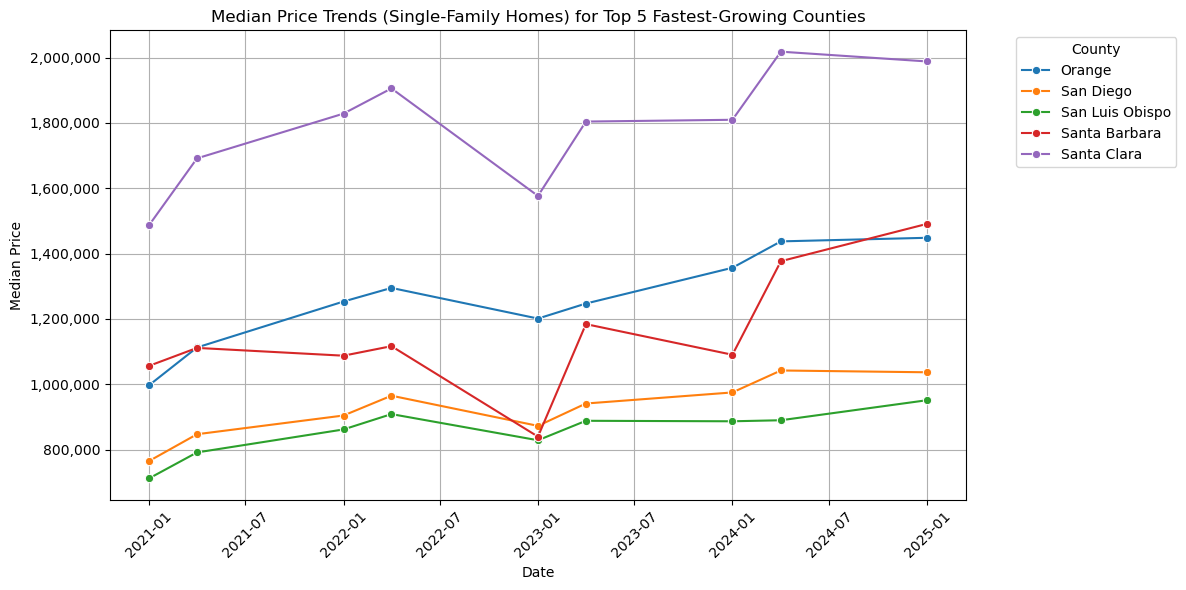

In [169]:
top_counties = results_df.head(5)["County"].tolist() # select top counties

top_df = car_recent_dfs_master[car_recent_dfs_master["County"].isin(top_counties)].copy() # filter dataframe for the top counties

plt.figure(figsize = (12, 6)) # plot median prices overtime
sns.lineplot(data = top_df, x = "Date", y = "MedianPrice", hue = "County", marker = "o")

plt.title("Median Price Trends (Single-Family Homes) for Top 5 Fastest-Growing Counties")
plt.xlabel("Date")
plt.ylabel("Median Price")

formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title = "County", bbox_to_anchor = (1.05, 1), loc = "upper left")

plt.xticks(rotation = 45)
plt.tight_layout()
plt.grid()
plt.show()
